In [22]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torch.nn.init as init
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_torch(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

class gamma_layer(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(gamma_layer, self).__init__()
        self.H = nn.Parameter(torch.ones(output_channel, input_channel))
        self.b = nn.Parameter(torch.ones(output_channel))
        self.H.data.normal_(0, 0.1)
        self.b.data.normal_(0, 0.001)

    def forward(self, x):
        H = torch.abs(self.H)
        x = F.linear(x,H)
        return torch.tanh(x)


In [23]:
intermediate_dim = 64
threshold = 0.0001
beta = 0.001
test_batch_size=1000
channel_noise_arg = 0.3162
batch_size = 128
epochs = 100
lr = 0.001
gamma = 0.5
weights = 'MNIST_model_dim:64_beta:0.001_accuracy:85.7180_model.pth'

In [24]:
class gamma_function(nn.Module):

    def __init__(self):
        super(gamma_function, self).__init__()
        self.f1 = gamma_layer(1,16)
        self.f2 = gamma_layer(16,16)
        self.f3 = gamma_layer(16,16)
        self.f4 = gamma_layer(16,intermediate_dim)
        
    def forward(self, x):
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        x = self.f4(x)
        return x

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(784, intermediate_dim)
        self.fc2 = nn.Linear(intermediate_dim, 1024)
        self.fc2_2 = nn.Sequential(
                        nn.Linear(1,16),
                        nn.ReLU(),
                        nn.Linear(16,16),
                        nn.ReLU(),
                        nn.Linear(16,16),
                        nn.ReLU()
                        )
        self.fc3 = nn.Linear(1024 + 16, 256)
        self.fc4 = nn.Linear(256, 10)
        self.gamma_mu = gamma_function().to(device)
        self.upper_tri_matrix = torch.triu(torch.ones((intermediate_dim,intermediate_dim))).to(device)

    def get_mask(self, mu, threshold=threshold):
        hard_mask = (mu > threshold).float()
        return hard_mask

    def get_mask_test(self, channel_noise, threshold = threshold):
        mu = self.gamma_mu(channel_noise)
        alpha = F.linear(mu, self.upper_tri_matrix)
        mu = torch.clamp(mu,min = 1e-4)
        hard_mask = (alpha > threshold).float()
        return hard_mask, alpha

    def forward(self, x, noise = 0.2):
        x = x.view(-1, int(x.nelement() / x.shape[0]))

        weight = self.fc1.weight
        bias = self.fc1.bias
        l2_norm_squared = torch.sum(weight.pow(2),dim = 1) + bias.pow(2)
        l2_norm = l2_norm_squared.pow(0.5)
        fc1_weight = (weight.permute(1,0) / l2_norm).permute(1,0)
        fc1_bias = bias / l2_norm
        x = F.linear(x, fc1_weight, fc1_bias)

        # Dynamic Channel Conditions
        if self.training:
            #b = torch.bernoulli(1/7.0*torch.ones(1))
            b = torch.bernoulli(1/5.0*torch.ones(1))
            if b > 0.5:
                channel_noise = torch.ones(1) * 0.3162
            else:
                channel_noise = torch.rand(1)*0.27 + 0.05
            #channel_noise = torch.rand(1)*0.27 + 0.05
        else:
            channel_noise = torch.FloatTensor([1]) * noise
        channel_noise = channel_noise.to(device)
        noise_feature = self.fc2_2(channel_noise)
        noise_feature = noise_feature.expand(x.size()[0],16)
        mu = self.gamma_mu(channel_noise)
        mu = F.linear(mu, self.upper_tri_matrix)
        mu = torch.clamp(mu,min = 1e-4)
        x = torch.tanh(mu * x)
        KL = self.KL_log_uniform(channel_noise**2/(x.pow(2)+1e-4))

        if self.training:
            x = (x * self.get_mask(mu) - x).detach() + x
            # Gaussian channel noise
            x = x + torch.randn_like(x) * channel_noise * self.get_mask(mu)
        else:
            # Gaussian channel noise
            x = x + torch.randn_like(x) * channel_noise
            x = x * self.get_mask(mu)

        x = F.relu(self.fc2(x))
        x = torch.cat((x,noise_feature),dim=1)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return F.log_softmax(x, dim=1), KL * (0.1 / channel_noise)

    def KL_log_uniform(self,alpha_squared):
        k1 = 0.63576
        k2 = 1.8732
        k3 = 1.48695
        batch_size = alpha_squared.size(0)
        KL_term = k1 * F.sigmoid(k2 + k3 * torch.log(alpha_squared)) - 0.5 * F.softplus(-1 * torch.log(alpha_squared)) - k1

        return - torch.sum(KL_term) / batch_size


In [33]:
import math
def train(model, device, train_loader, optimizer, epoch):
    total_izy = 0
    num_batches = len(train_loader)
    total_izx = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, KL = model(data)
        if  epoch <=-1:
          loss = F.nll_loss(output, target)
        else:
          anneal_ratio = min(1,(epoch - 5)/10)
          loss = F.nll_loss(output, target) + beta * KL * anneal_ratio
          total_izx +=  KL.item()
          izy = math.log(10, 2) - F.nll_loss(output, target).div(math.log(2))
          loss = beta*KL - izy
          loss = F.nll_loss(output, target) + beta * KL * anneal_ratio
          total_izy += izy.item()  # Accumulate the izy value
        loss.backward()
        optimizer.step()
    avg_izy = total_izy / num_batches
    avg_izx = total_izx / num_batches
    
    print(f"Epoch {epoch} -, Average izy: {avg_izy}, Average izx: {avg_izx}")
    return avg_izy, avg_izx

In [27]:
def test(model, device, test_loader,noise = 0.2):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, KL = model(data,noise = noise)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    hard_mask, mu = model.get_mask_test(torch.FloatTensor([noise]).to(device))
    index = torch.nonzero(torch.lt(hard_mask,0.5)).squeeze(1)
    pruned_number = index.size()[0]

    return 100. * correct / len(test_loader.dataset), pruned_number

In [28]:
izy_list = []
izx_list = []
acc_list = []
def main_train():
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 5e-5)
    scheduler = StepLR(optimizer, step_size=45, gamma=gamma)
    
    test_acc = 0
    pruned_dim = 0
    saved_model = {}

    for epoch in range(1, epochs + 1):
        if epoch % 10 == 1:
            train_loader = torch.utils.data.DataLoader(
                datasets.FashionMNIST('./data', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (0.5,))
                               ])),
                batch_size=batch_size, shuffle=True, **kwargs)
        print('\nepoch:',epoch)
        izy,izx = train(model, device, train_loader, optimizer, epoch)
        izy_list.append(izy)
        izx_list.append(izx)
        scheduler.step()
        accuracy = 0
        t = 1
        for i in range (t):
            acc, pruned_number = test(model, device, test_loader, channel_noise_arg)
            accuracy += acc
        print('Test Accuracy:',accuracy/t, 'Pruned dim',pruned_number,'Activated dim:',intermediate_dim - pruned_number)
        accuracy = accuracy/t
        acc_list.append(accuracy)

    #     if epoch > 10:
    #         if (accuracy > test_acc and pruned_number == pruned_dim) or pruned_number > pruned_dim:
    #             test_acc = accuracy
    #             pruned_dim = pruned_number
    #             saved_model = copy.deepcopy(model.state_dict())
    # print('Best Accuray:',test_acc,'pruned_number:',pruned_dim,'activated_dim:',intermediate_dim - pruned_dim)
    # torch.save({'model': saved_model}, './MNIST_model_dim:{}_beta:{}_accuracy:{:.4f}_model.pth'.format(intermediate_dim - pruned_dim, beta, test_acc))


In [29]:
def main_test():
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('./data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

    model = Net().to(device)
    model.load_state_dict(torch.load(weights, map_location=torch.device('cpu'))['model'])

    accuracy = 0
    t = 20
    for i in range (t):
        acc, pruned_dim = test(model, device, test_loader, channel_noise_arg)
        accuracy += acc
    print('Noise level:',channel_noise_arg, 'Test Accuracy:', accuracy/t, 'Pruned dim:', pruned_dim, 'Activated dim:', intermediate_dim - pruned_dim)


In [34]:
main_train()


epoch: 1
Epoch 1 -, Average izy: 2.535460614192206, Average izx: 75.8769435353879
Test Accuracy: 80.14 Pruned dim 0 Activated dim: 64

epoch: 2


KeyboardInterrupt: 

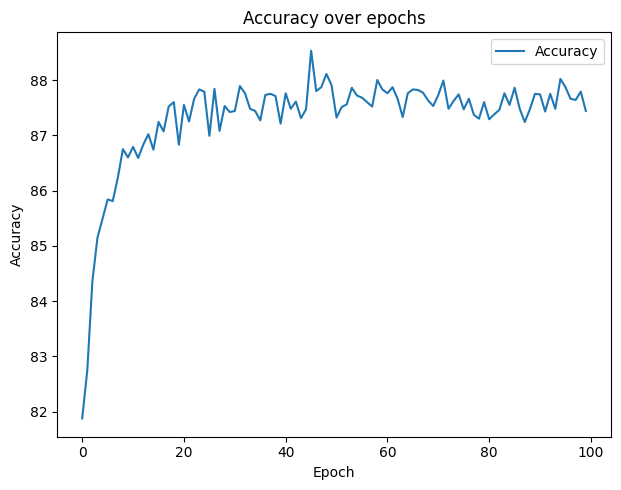

In [31]:
import matplotlib.pyplot as plt
# Plotting the metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(range(epochs), acc_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.tight_layout()
plt.show()

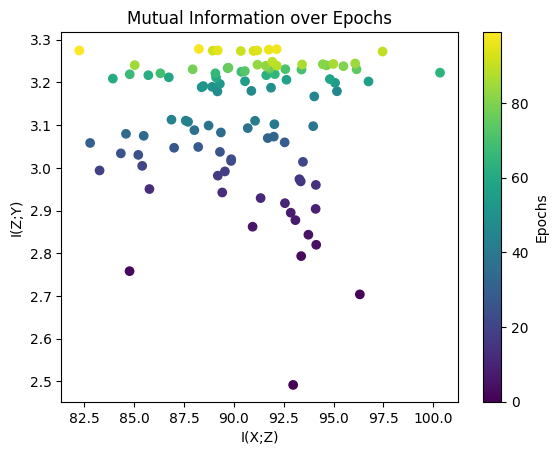

In [32]:
plt.scatter(izx_list, izy_list, c=range(epochs), cmap='viridis', marker='o')
plt.colorbar(label='Epochs')
plt.xlabel('I(X;Z)')
plt.ylabel('I(Z;Y)')
plt.title('Mutual Information over Epochs')
plt.show()